In [17]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from selfregulation.utils.utils import get_behav_data
from sklearn.linear_model import ElasticNet, LinearRegression, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
from sklearn.pipeline import make_pipeline
from fancyimpute import SoftImpute
% matplotlib inline

### Define Helper functions


In [466]:
def remove_missing(datasets):
    datasets = [np.array(i) for i in datasets]
    concat_data = np.hstack(datasets)
    data_rows = np.where(np.all(~np.isnan(concat_data),axis=1))[0]
    cleaned_data = []
    for data in datasets:
        cleaned_data.append(data[data_rows,:])
    return cleaned_data

# using for speed, for the time being
def SoftImpute_df(data):
    if data.isnull().sum().sum()>0:
        imputed_mat = SoftImpute(verbose=False).complete(data)
        return pd.DataFrame(data=imputed_mat, columns=data.columns, index=data.index)
    else:
        print("No missing values, no imputation necessary")
        return data

def split_task(data,task):
    target = data.filter(regex = '^'+task+'\.')
    features = data.drop(target.columns, axis=1)
    return features, target

def run_FA(n_components,data,cv):
    fa=FactorAnalysis(n_components)
    scores = []
    # cross-validate fit across different train/test splits
    for train_index, test_index in cv.split(data.values):
        data_train, data_test = data.iloc[train_index], \
                                data.iloc[test_index]
        # Impute (replace with missForest later)
        imputed_train = SoftImpute_df(data_train)
        imputed_test = SoftImpute_df(data_test)
        # Scale data
        scaler = StandardScaler()
        scaled_train = scaler.fit_transform(imputed_train)
        scaled_test = scaler.transform(imputed_test)
        # fit model on training
        fa.fit(scaled_train)
        # score on test set
        scores.append(fa.score(scaled_test))
    #average score across kfolds
    score = np.mean(scores)
    return score, fa

def find_optimal_components(data, method='sklearn', cv=None):
    if method == 'sklearn':
        assert cv, "Must Supply a CV if using sklearn"
        # find best number of components
        n_components = range(1,12)
        best_c = 0
        component_scores = []
        for c in n_components:
            score, fa = run_FA(c,data,cv)
            component_scores.append(score)
        best_c = np.argmax(component_scores)+1
        print('Best Component: ', best_c)
        return best_c, component_scores
    elif method == 'psych':
        BICs = []
        outputs = []
        n_components = range(1,12)
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(data)
        for c in n_components:
            fa, output = psychFA(scaled_data, c, method='ml')
            BICs.append(output['BIC'])
            outputs.append(output)
        best_c = np.argmin(BICs)+1
        print('Best Component: ', best_c)
        return best_c, BICs

In [508]:
def data_transform(data, transforms=[]):
    features = None
    # Impute (replace with missForest later)
    imputed_data = SoftImpute_df(data)
    # Scale data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(imputed_data)
    for trf in transforms:
        # transform data
        transformed_data = trf.transform(scaled_data)
        if features is None:
            features = transformed_data
        else:
            features = np.hstack((features,transformed_data))
    return features

def data_fit_transform(data, n_components, method=FactorAnalysis):
    features = None
    if type(n_components) != list:
        n_components = [n_components]
    # Impute (replace with missForest later)
    imputed_data = SoftImpute_df(data)
    # Scale data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(imputed_data)
    trfs = [] # store fitted transforms
    for c in n_components:
        trf=method(c)
        # fit model on features
        transformed_data = trf.fit_transform(scaled_data)
        trfs.append(trf)
        if features is None:
            features = transformed_data
        else:
            features = np.hstack((features,transformed_data))
    return features, trfs

def out_of_task_prediction(data, task=None, n_components=None):
    # remove task
    if task is None:
        tasks = np.unique([i.split('.')[0] for i in data.columns])
        task = np.random.choice(tasks)
        print("Using task: %s" % task)
    features,target = split_task(data,task)
    # get reduced feature space
    FA_features, fa_trfs = data_fit_transform(features, n_components)
    PCA_features, pca_trfs = data_fit_transform(features, n_components, method=PCA)
    # remove nans
    target, FA_features, PCA_features = remove_missing([target,
                                                        FA_features,
                                                        PCA_features])
    # predict target
    fa_lr = LinearRegression()
    fa_lr.fit(FA_features, target)
    pca_lr = LinearRegression()
    pca_lr.fit(PCA_features, target)
    return fa_trfs, fa_lr, pca_trfs, pca_lr

def out_of_task_predictionCV(data,task,n_components=None,verbose=True):
    if n_components is None:
        # find optimal number of dimensions
        kf = KFold(n_splits = 4)
        n_components, component_scores = find_optimal_components(data,cv=kf)
    # cross-validated out of task prediction
    kf = KFold(n_splits=4)
    FA_scores = []
    PCA_scores = []
    for train_index, test_index in kf.split(data.values):
        data_train, data_test = data.iloc[train_index], \
                                data.iloc[test_index]
        
        fa_trfs, fa_lr, pca_trfs, pca_lr = out_of_task_prediction(data_train, task, n_components)
        # remove task from test data
        f,t = split_task(data_test,task)
        task_variables = t.columns
        # transform using the transforms learned with train
        fa_features = data_transform(f,fa_trfs)
        pca_features = data_transform(f,pca_trfs)
        # remove nas
        fa_features,pca_features,t = remove_missing([fa_features,pca_features,t])
        # score prediction
        FA_score = {}
        PCA_score = {}
        fa_predicted_vars = fa_lr.predict(fa_features)
        pca_predicted_vars = pca_lr.predict(pca_features)
        grouped = list(zip(task_variables,t.T,fa_predicted_vars.T, pca_predicted_vars.T))
        for name,var,fa_predicted,pca_predicted in grouped: # iterate over columns:
            FA_score[name] = metrics.r2_score(var, fa_predicted)
            PCA_score[name] = metrics.r2_score(var, pca_predicted)
        FA_scores.append(FA_score)
        PCA_scores.append(PCA_score)
    FA_scores = pd.DataFrame(FA_scores)
    PCA_scores = pd.DataFrame(PCA_scores)
    if verbose:
        print('*'*40)
        print('Leaving out task: %s' % task)
        for col in FA_scores:
            print('\nVariable: %s' % col)
            print("FA Accuracy: %0.2f (+/- %0.2f)" % (FA_scores[col].mean(), FA_scores[col].std() * 2))
            print("PCA Accuracy: %0.2f (+/- %0.2f)" % (PCA_scores[col].mean(), PCA_scores[col].std() * 2))

    return FA_scores.mean(), PCA_scores.mean()

In [ ]:
    predicted = cross_val_predict(lr, FA_transformed_features, target, cv=10)
    predicted = pd.DataFrame(predicted,index=target.index,columns=[i+'_pred' for i in target.columns])
    df = pd.concat([target,predicted], axis=1)
sns.heatmap(df.sort_index(axis=1).corr())

### Load Data

In [218]:
datafile = 'Complete_01-16-2017'
data = get_behav_data(dataset=datafile, file = 'taskdata_clean.csv')


Getting datasets...:
 /home/ian/Experiments/expfactory/Self_Regulation_Ontology/Data/Complete_01-16-2017


### Example of out of sample prediction

We remove all variables from one task from the data matrix. Then we reduce the dimensionality using FA, which we use to predict the left out variables. We then assess the cross-validated predictive accuracy, and then visualize the optimal coefficients to predict each variable

In [509]:
# show one example
task_name = 'choice_reaction_time'
FA_score, PCA_score= out_of_task_predictionCV(data ,n_components=11, task=task_name)


****************************************
Leaving out task: choice_reaction_time

Variable: choice_reaction_time.hddm_drift
FA Accuracy: 0.50 (+/- 0.13)
PCA Accuracy: 0.49 (+/- 0.14)

Variable: choice_reaction_time.hddm_non_decision
FA Accuracy: 0.19 (+/- 0.19)
PCA Accuracy: 0.19 (+/- 0.17)

Variable: choice_reaction_time.hddm_thresh
FA Accuracy: 0.16 (+/- 0.11)
PCA Accuracy: 0.16 (+/- 0.11)


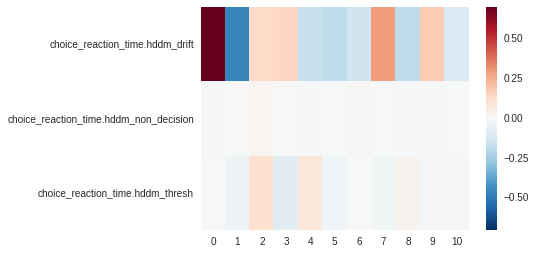

In [510]:
fa_trfs, fa_lr, pca_trfs, pca_lr = out_of_task_prediction(data,n_components=11,task=task_name)
f,task = split_task(data,task_name)
coef_df = pd.DataFrame(fa_lr.coef_,index=task.columns)
sns.heatmap(coef_df)

In [ ]:
# run it on every task
tasks = np.unique([i.split('.')[0] for i in data.columns])
scores = pd.DataFrame()
for task in tasks:
    FA_scores, PCA_scores = out_of_task_predictionCV(data ,n_components=11, 
                                                     task=task,verbose=False)
    scores = pd.concat([scores,pd.DataFrame({'FA':FA_scores,'PCA':PCA_scores})])

Average Reconstruction Score
FA     0.123856
PCA    0.126364
dtype: float64


/home/ian/anaconda2/envs/py34/lib/python3.4/site-packages/seaborn/categorical.py:2342: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


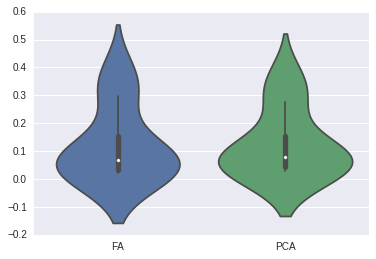

In [536]:
# plot score for FA and PCA reconstruction
print('Average Reconstruction Score')
print(scores.mean())
sns.violinplot(scores)

In [21]:
# tasks in order of FA reconstruction success
score_df.sort_values(by='FA', ascending=False)

,FA,PCA,RR
discount_titrate,0.623210,0.581259,0.544277
kirby,0.487201,0.401002,0.469557
choice_reaction_time,0.479722,0.476971,0.403934
ravens,0.452720,0.443127,0.347550
adaptive_n_back,0.292782,0.286780,0.133343
simple_reaction_time,0.290793,0.292702,0.241212
simon,0.287152,0.281226,0.226087
bickel_titrator,0.262012,0.245889,0.002390
go_nogo,0.246710,0.237814,0.094728
shape_matching,0.231641,0.224260,0.106970
